In [130]:
import pandas as pd
import cv2
import sys
import os

sys.path.append("../../")
from src import utils
from src.dataset2D import MRIDataset2D
from src.models2D import Model2DTimm
import albumentations as A
from albumentations.pytorch import ToTensorV2

utils.set_seed(42)

results_dir = '../../results/preprocessed_data/'
labels=["Noise", "Zipper", "Positioning", "Banding", "Motion", "Contrast", "Distortion"]


df_train = pd.read_csv(os.path.join(results_dir, 'df_train_imgs.csv'))
df_test = pd.read_csv(os.path.join(results_dir, 'df_test_imgs.csv'))
df_train.head(2)


filename  Noise  Zipper  Positioning  Banding  Motion  \
0  LISA_0001_LF_axi.nii.gz      0       0            0        0       0   
1  LISA_0001_LF_axi.nii.gz      0       0            0        0       0   

   Contrast  Distortion                                               path  \
0         0           0  /data/cristian/projects/med_data/rise-miccai/t...   
1         0           0  /data/cristian/projects/med_data/rise-miccai/t...   

  patient_id  dim_x  dim_y  dim_z  spacing_x  spacing_y  spacing_z view  \
0  LISA_0001     36    120    146        5.0        1.5        1.5  axi   
1  LISA_0001     36    120    146        5.0        1.5        1.5  axi   

                                            img_path  \
0  /data/cristian/projects/med_data/rise-miccai/t...   
1  /data/cristian/projects/med_data/rise-miccai/t...   

                                            npy_path     ratio  
0  /data/cristian/projects/med_data/rise-miccai/t...  0.014792  
1  /data/cristian/projects/med_data/rise-miccai/t...  0.014792

In [131]:

class args_class:
    def __init__(self):
        self.device = "cuda:3"
        self.label_cols = "Noise,Zipper,Positioning,Banding,Motion,Contrast,Distortion".split(",")
        self.seed = 42
        self.n_splits = 3
args = args_class()

In [132]:
# 📄 Leer CSVs
df_train_original = pd.read_csv(os.path.join(results_dir, 'df_train.csv'))

df_train["patient_id"] = df_train["filename"].str.extract(r"(LISA_\d+)")

df_train,df_test_back = utils.robust_split_by_patient(df_train_original,df_train,args)
df_test_back.shape

🎯 Labels usados para estratificación: ['Positioning', 'Banding']
🟡 Casos raros: 1 — Casos comunes: 477
Train    : Noise true dist: [384  49  45]
Train    : Zipper true dist: [362  93  23]
Train    : Positioning true dist: [423  43  12]
Train    : Banding true dist: [452  14  12]
Train    : Motion true dist: [345  75  58]
Train    : Contrast true dist: [333 123  22]
Train    : Distortion true dist: [391  51  36]
Testback : Noise true dist: [40 10  1]
Testback : Zipper true dist: [34 12  5]
Testback : Positioning true dist: [44  4  3]
Testback : Banding true dist: [49  1  1]
Testback : Motion true dist: [39  2 10]
Testback : Contrast true dist: [40 11  0]
Testback : Distortion true dist: [43  4  4]


(2040, 20)

In [133]:
df_train_original["patient_id"]

0      LISA_0001
1      LISA_0001
2      LISA_0001
3      LISA_0002
4      LISA_0002
         ...    
524    LISA_2096
525    LISA_2097
526    LISA_2098
527    LISA_2099
528    LISA_2100
Name: patient_id, Length: 529, dtype: object

In [134]:
# ✅ Crea el dataset (usa `use_augmentation=False` para visualización clara)
dataset_vis = MRIDataset2D(df=df_test_back,is_train=True,use_augmentation=False,is_numpy=True,labels=labels)

100%|██████████| 2040/2040 [00:00<00:00, 3963.83it/s]


In [135]:
import torch
model = Model2DTimm("maxvit_nano_rw_256.sw_in1k",1,7,3,0.3,True)
save_dir = "/data/cristian/projects/med_data/rise-miccai/task-1/2d_models/results/maxvit_nano_rw_256.sw_in1k2D_final"
fold = 0
model.load_state_dict(torch.load(f"{save_dir}/model_fold{fold}.pt"))

<All keys matched successfully>

In [138]:
label_cols = ["Noise", "Zipper", "Positioning", "Banding", "Motion", "Contrast", "Distortion"]
label_name = "Zipper"
label_idx = label_cols.index(label_name)

cnt = 0
idx = 0
list_idx = []
# 🔍 Recorremos el dataset hasta encontrar un ejemplo con Zipper == 2
while idx<len(dataset_vis):
    _, y, _, _ = dataset_vis[idx]  # y es tensor de shape (7,)
    if y[label_idx].item() == 2:
        cnt+=1
        list_idx.append(idx+15)
        idx+=40
        print(f"✅ Encontrado: idx={idx}, {label_name}=2")
        
    if cnt>10:
       break
    idx +=1

✅ Encontrado: idx=1120, Zipper=2
✅ Encontrado: idx=1200, Zipper=2
✅ Encontrado: idx=1720, Zipper=2
✅ Encontrado: idx=1880, Zipper=2
✅ Encontrado: idx=1921, Zipper=2


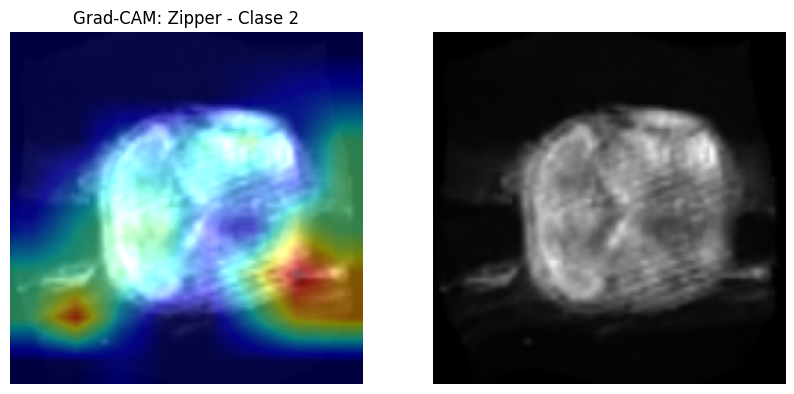

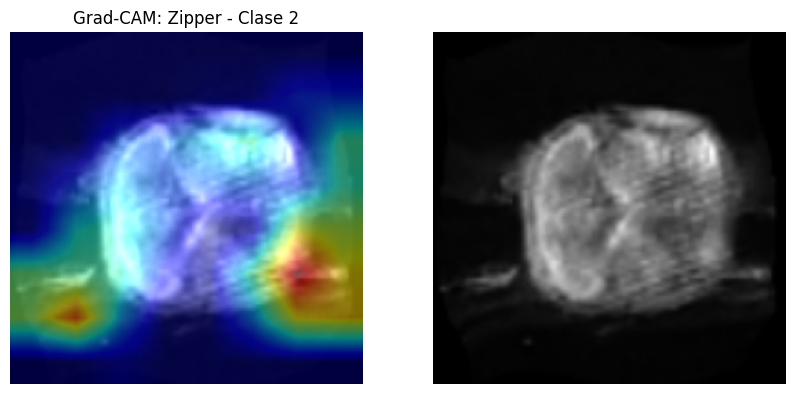

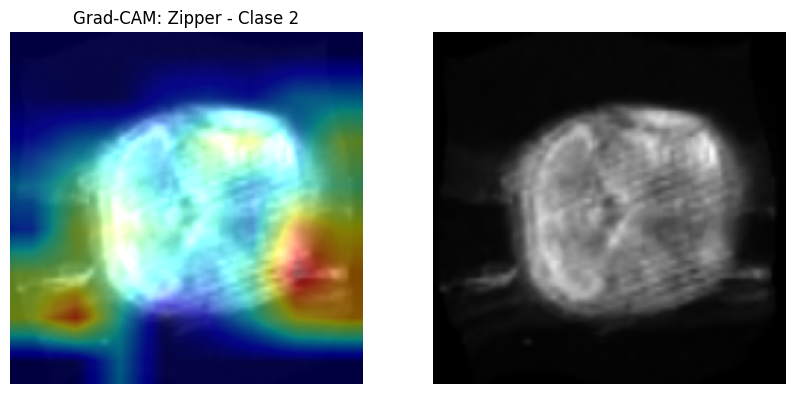

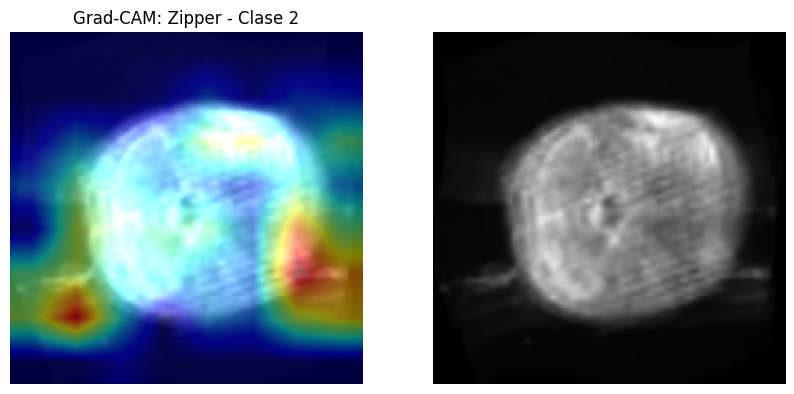

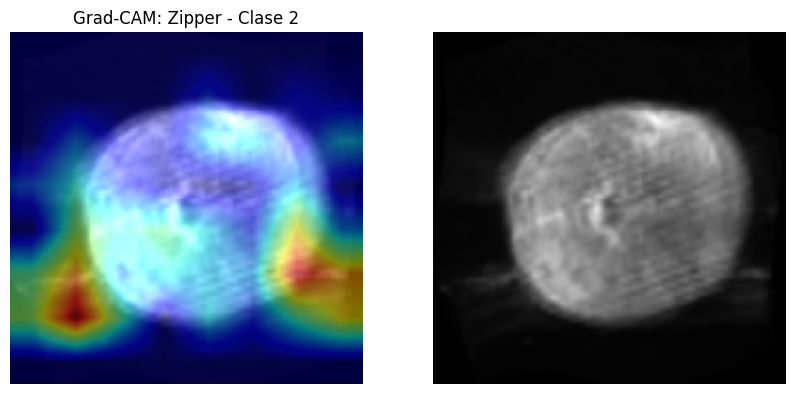

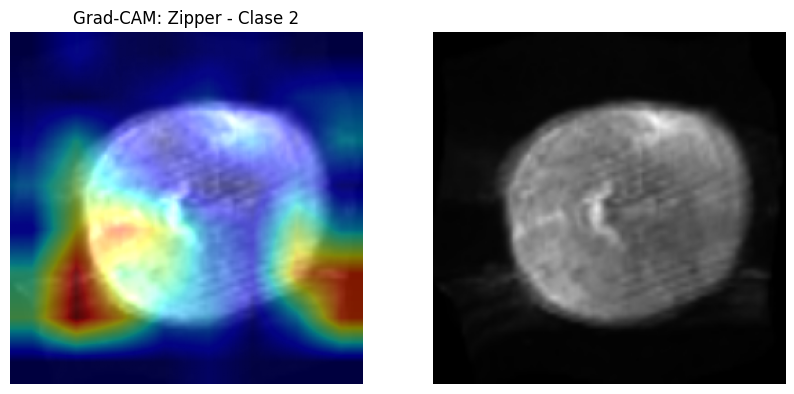

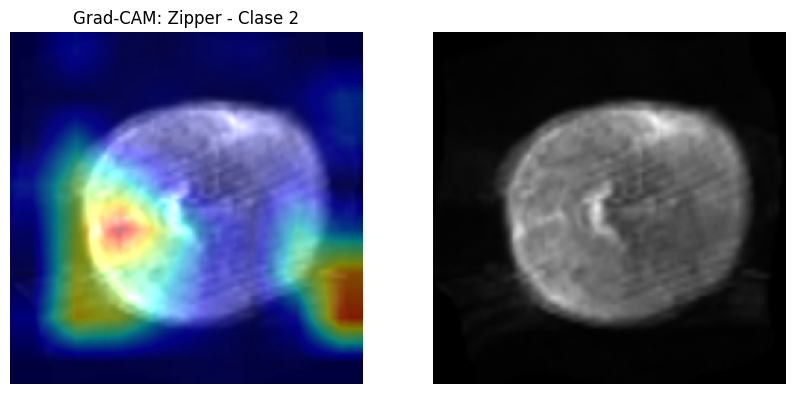

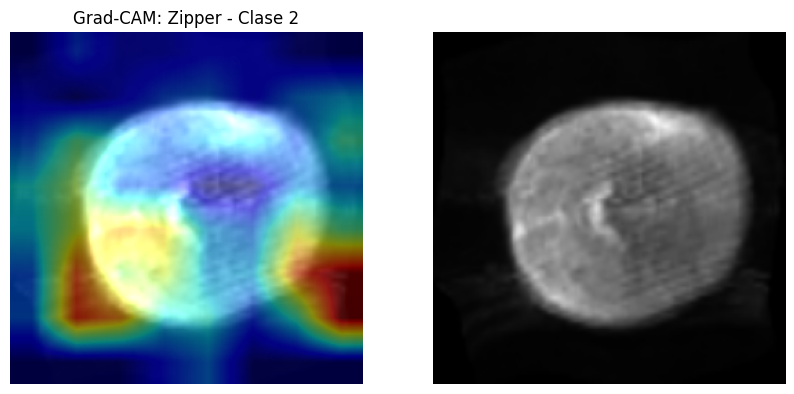

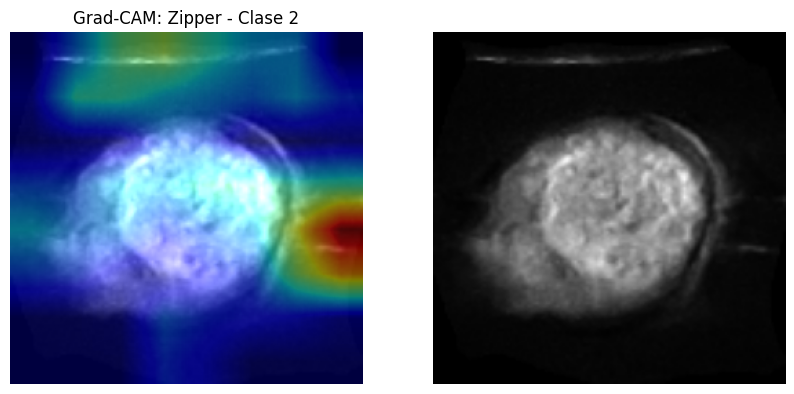

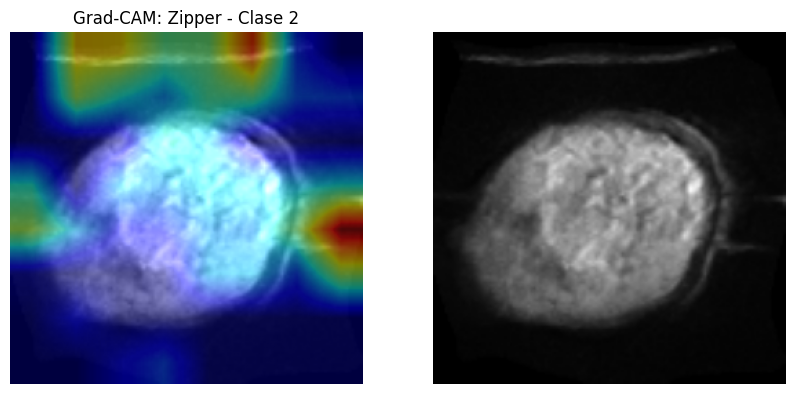

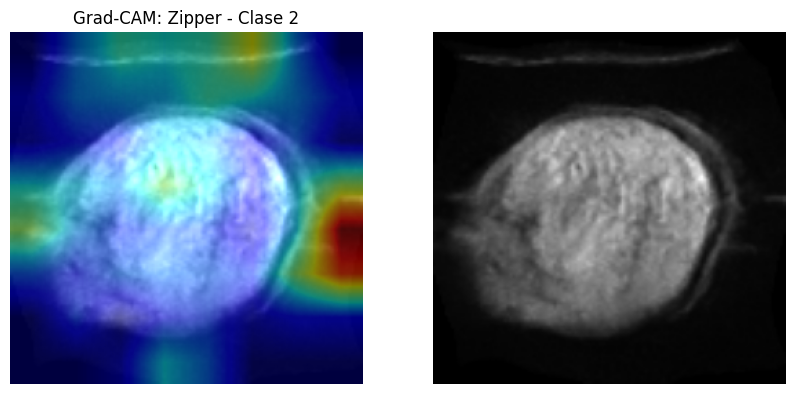

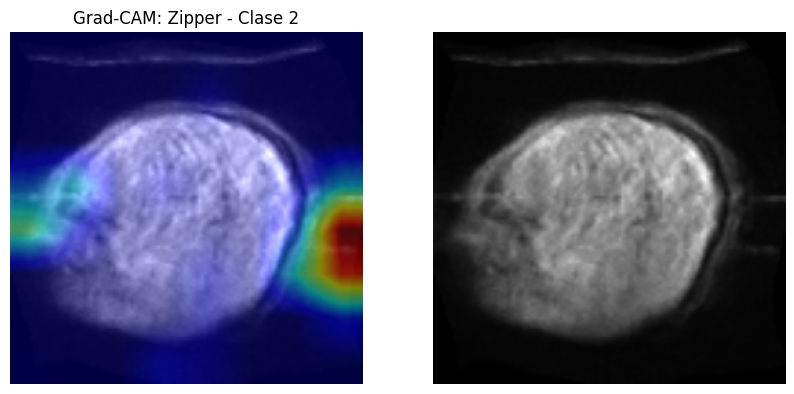

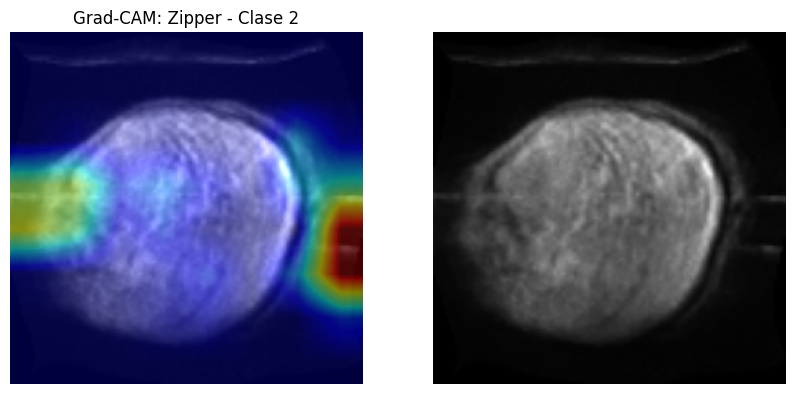

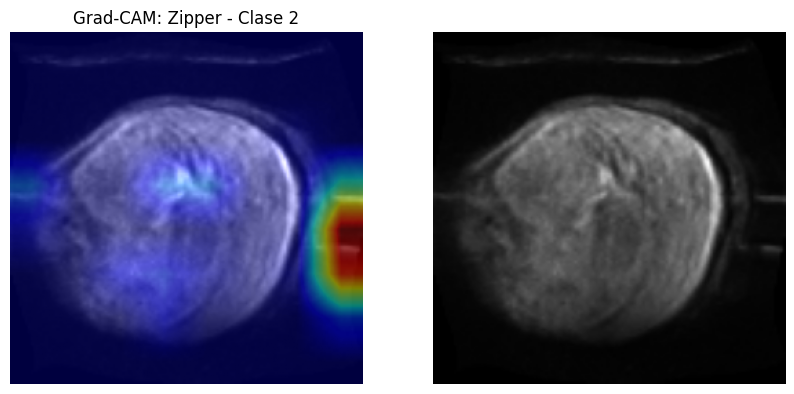

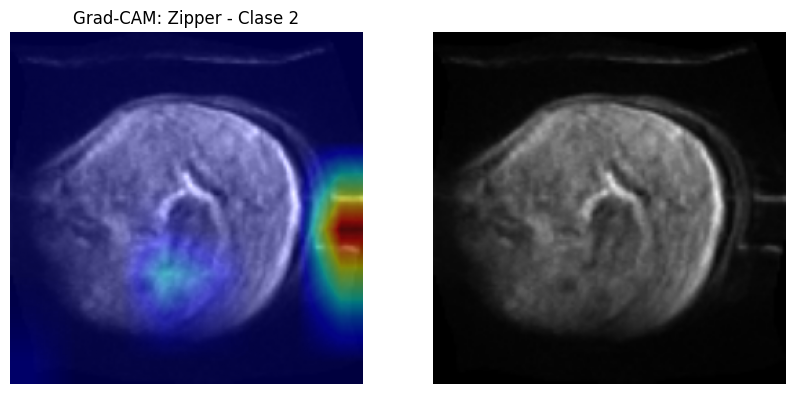

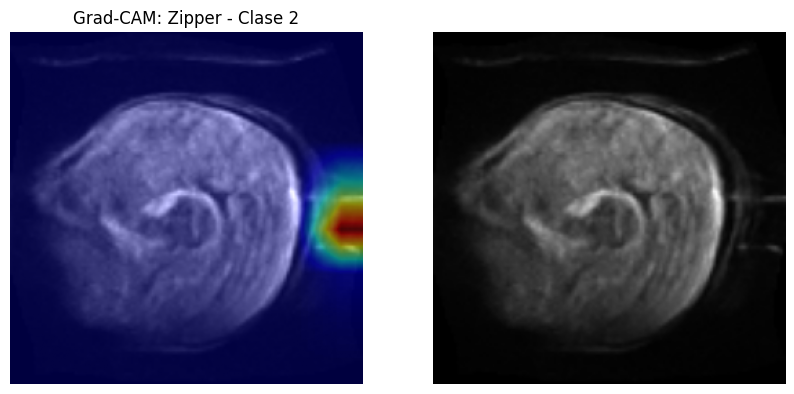

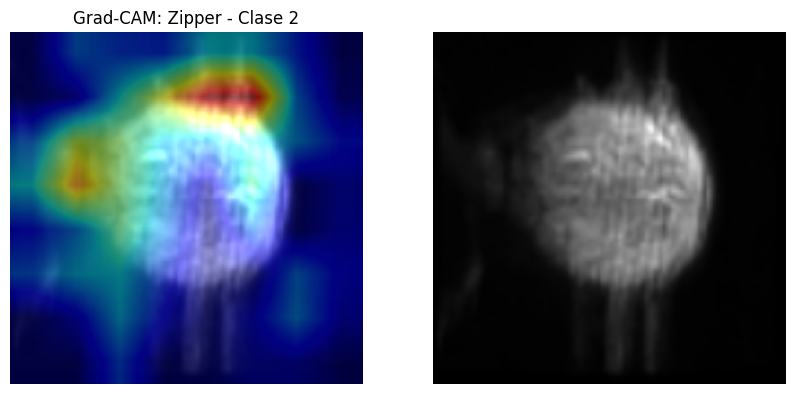

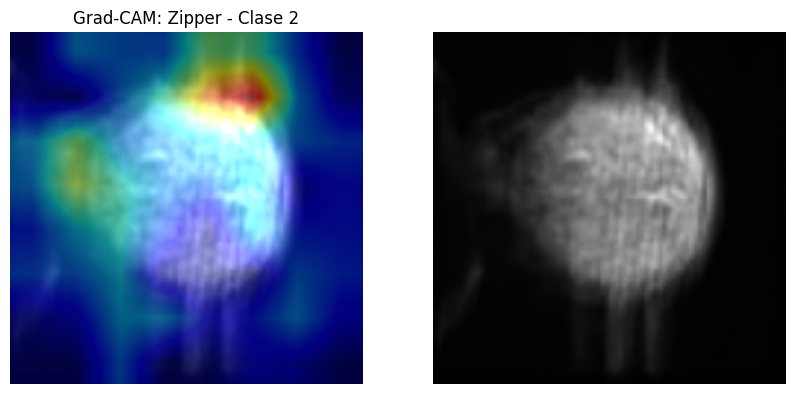

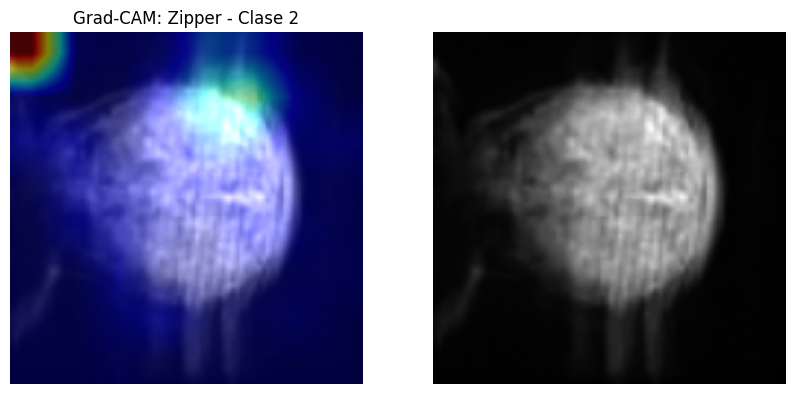

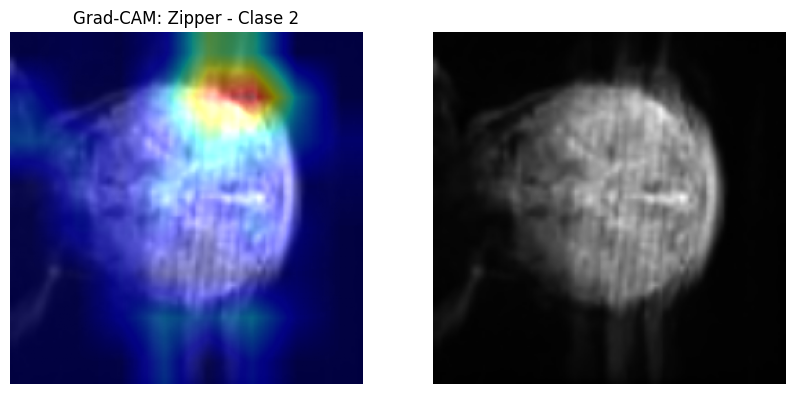

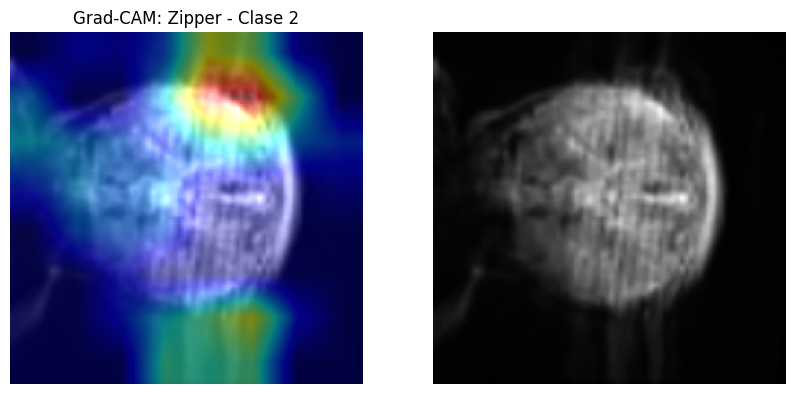

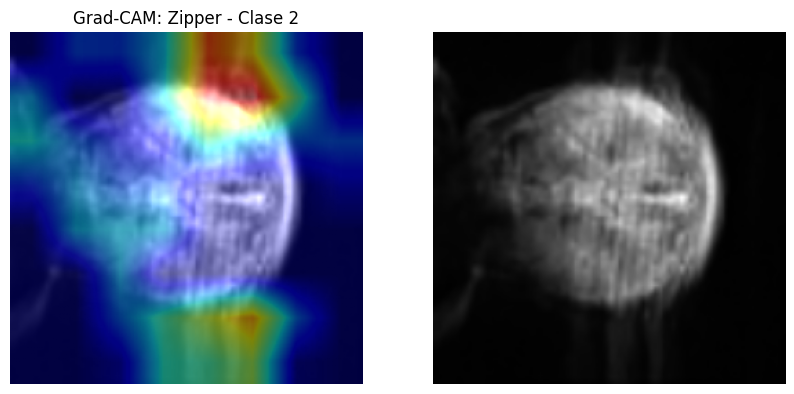

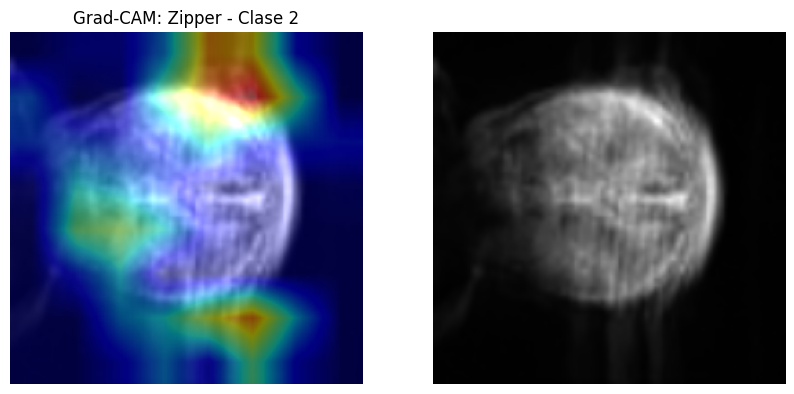

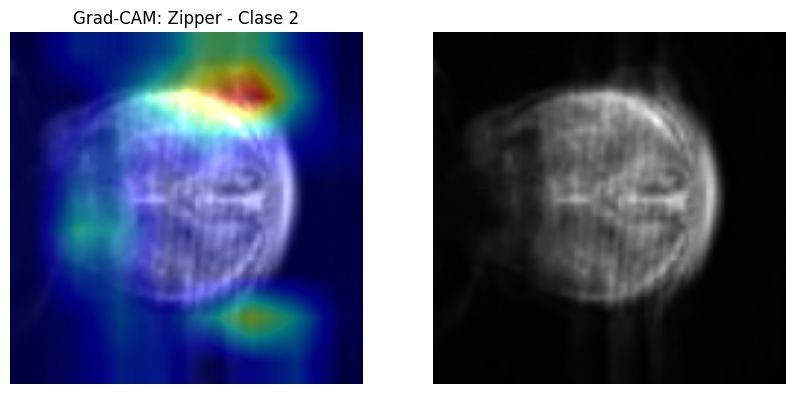

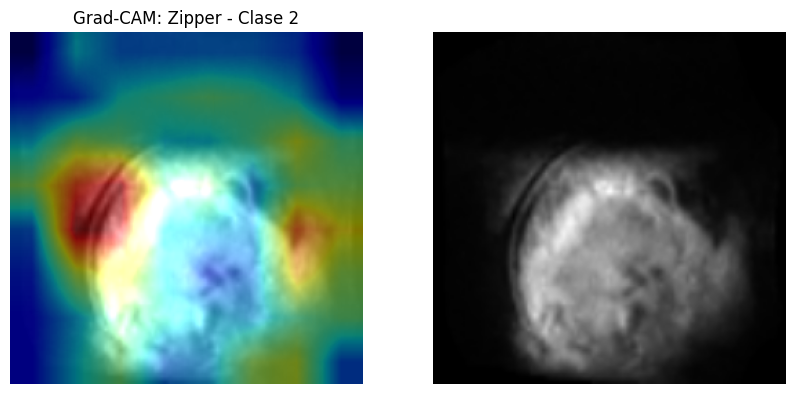

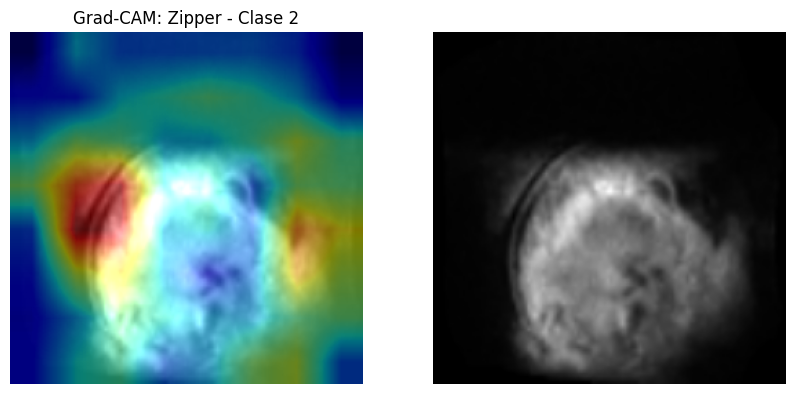

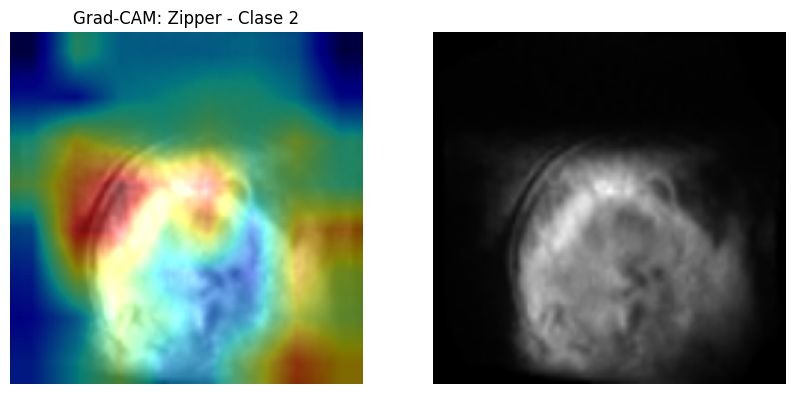

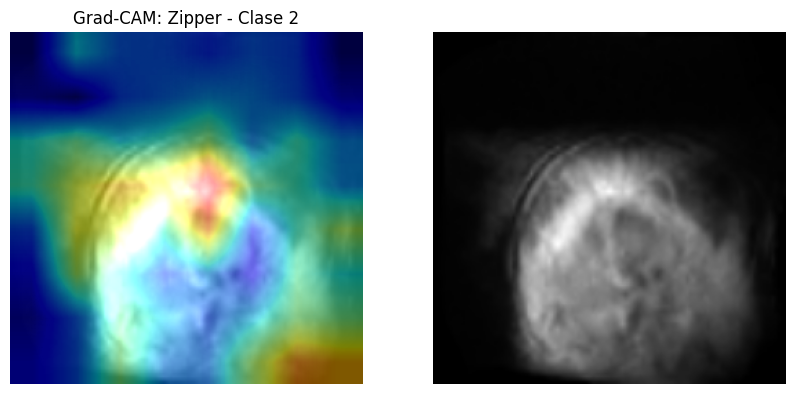

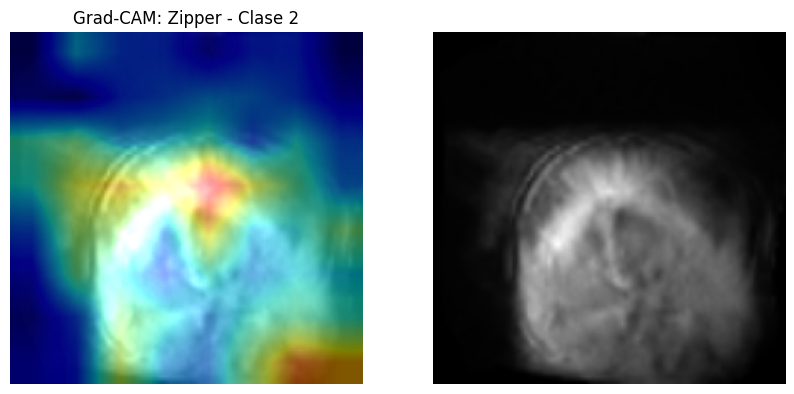

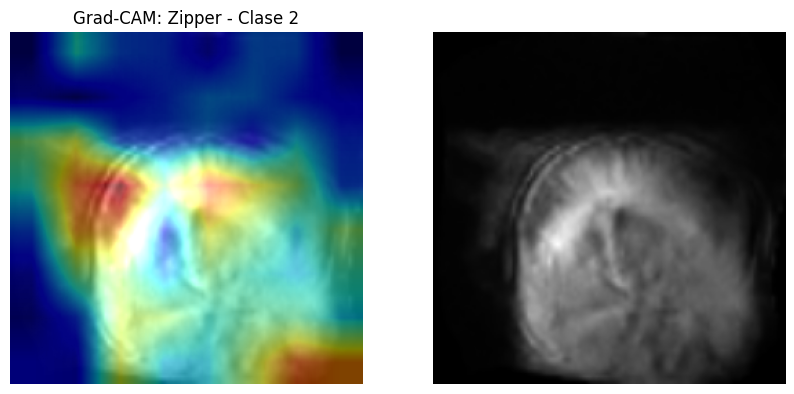

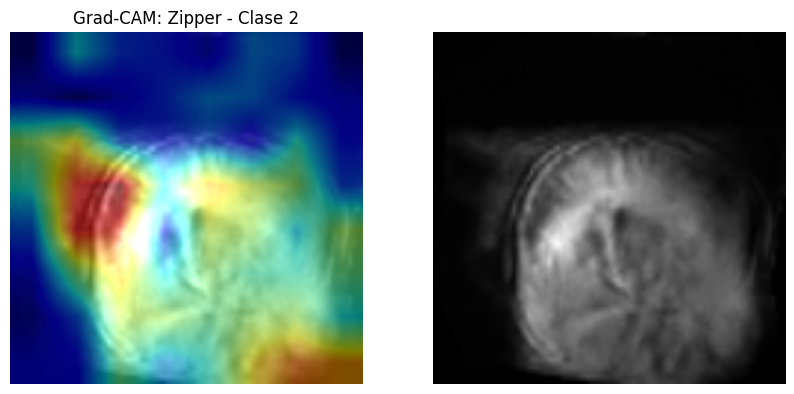

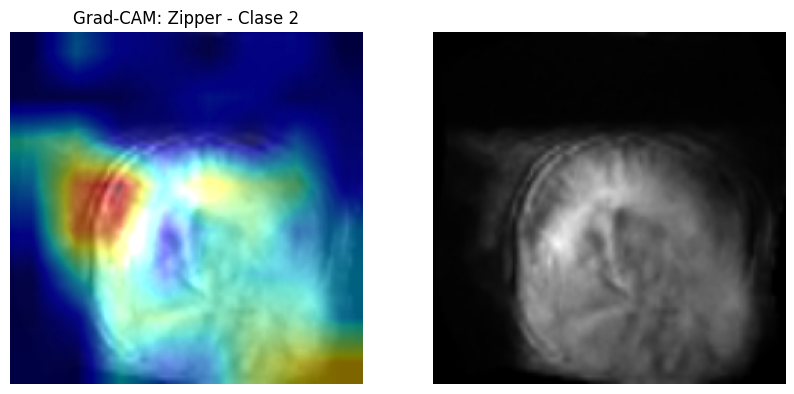

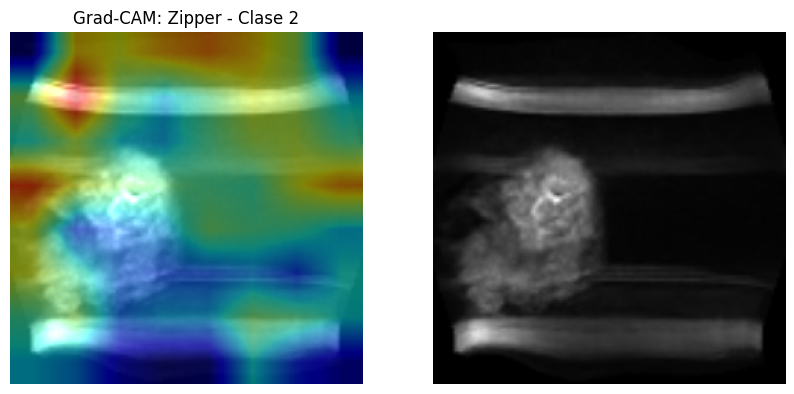

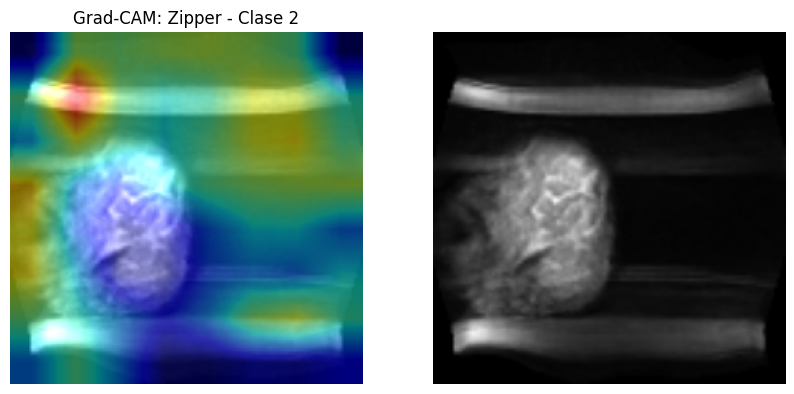

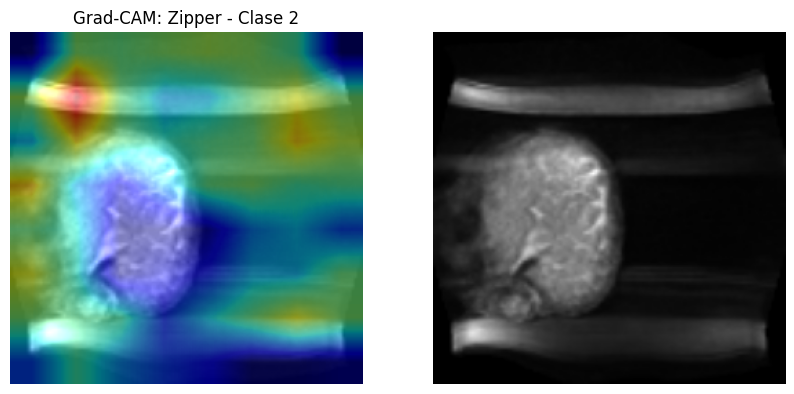

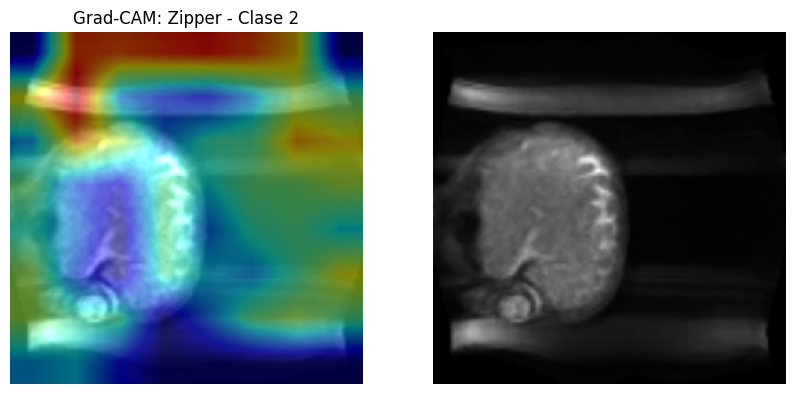

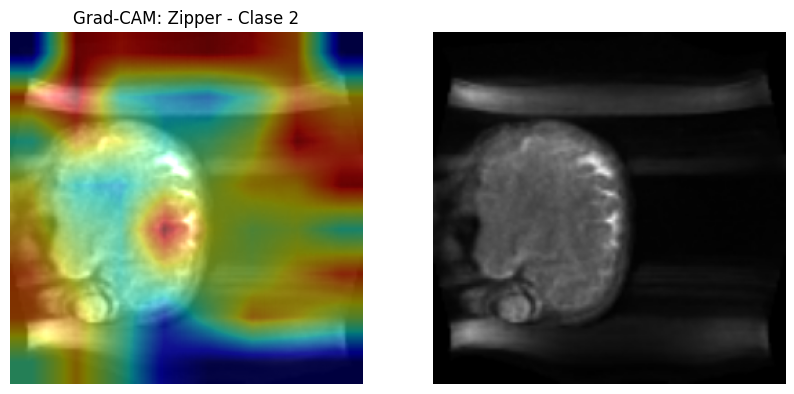

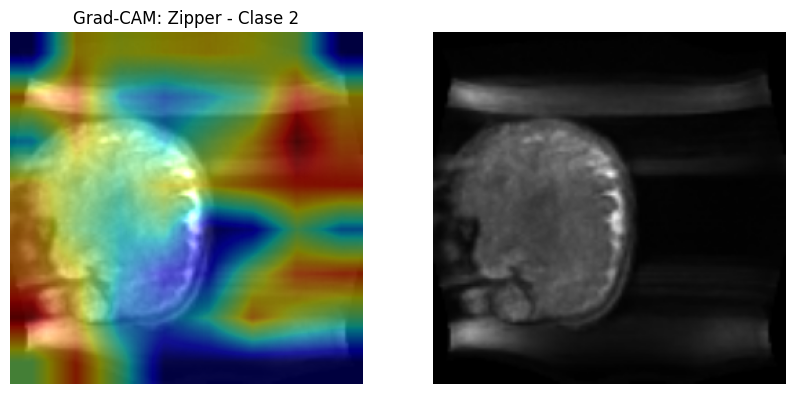

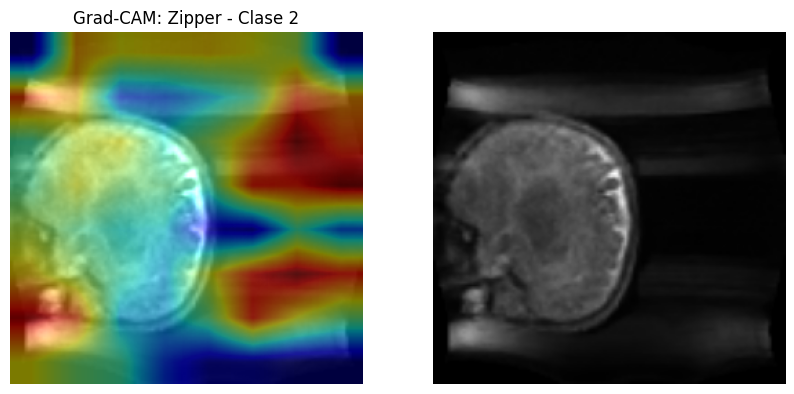

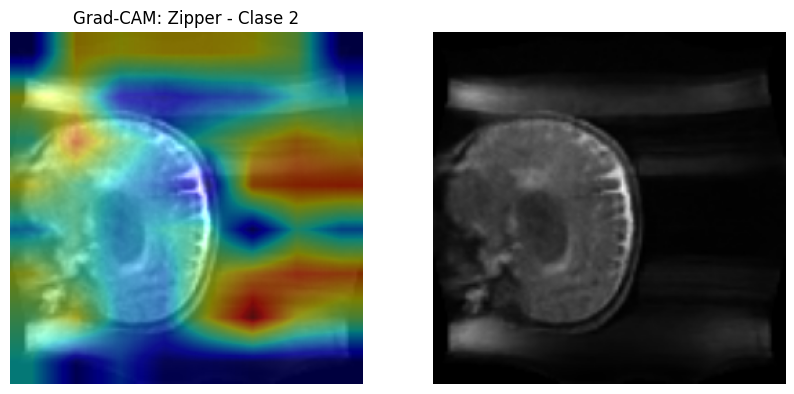

In [139]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Normalize
from PIL import Image
import numpy as np

# -----------------------------
# ⚙️ Carga modelo y set eval
model.to(args.device)
model.eval()

# 🔍 Extrae un ejemplo del dataset
for idy in list_idx:
  for idx in range(idy-4,idy+4):
    #idx = 3980  # cambia el índice según imagen que quieras ver
    x, y, path, view = dataset_vis[idx]   # x: (C, H, W)
    input_img = x.unsqueeze(0).to(args.device)
    view = view.unsqueeze(0).to(args.device)

    # -----------------------------
    # 🧠 Forward con hooks
    feature_map = None
    gradients = None

    def forward_hook(module, input, output):
        global feature_map
        feature_map = output.detach()

    def backward_hook(module, grad_in, grad_out):
        global gradients
        gradients = grad_out[0].detach()

    # ⛓️ Registrar hooks en la capa adecuada
  #  target_layer = model.backbone.stages[-1].blocks[-1].conv.norm2
    target_layer = model.backbone.stages[3].blocks[0].conv.norm2

    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    # 🎯 Forward
    output = model(input_img)  # shape (1, 7, 3)

    # Elige etiqueta y clase
    label_idx = args.label_cols.index(label_name)
    class_idx = 2

    # 🎯 Target score
    score = output[0, label_idx, class_idx]
    model.zero_grad()
    score.backward()

    # -----------------------------
    # 🔥 Grad-CAM
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * feature_map).sum(dim=1)
    cam = F.relu(cam)[0].cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # -----------------------------
    # 🎨 Visualización
    # Desnormalizar imagen
    original_img = x.cpu()
    if original_img.shape[0] == 1:
        original_img = torch.cat([original_img]*3, dim=0)  # Convertir a RGB si es 1 canal


    #original_img = Normalize(mean=[0.5]*3, std=[0.5]*3)(original_img)
    original_img = to_pil_image(original_img)

    # CAM -> Heatmap
    cam_img = Image.fromarray(np.uint8(cam * 255)).resize(original_img.size, Image.BILINEAR).convert("L")
    cam_img = np.array(cam_img) / 255
    heatmap = plt.cm.jet(cam_img)[..., :3]
    overlay = np.array(original_img)/ 255 + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)

    # Mostrar
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.title(f"Grad-CAM: {label_name} - Clase {class_idx}")
    plt.imshow(overlay)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(original_img)
    plt.axis("off")
    plt.show()
